In [8]:
import torch
import os
from PIL import Image
from transformers import AutoTokenizer, AutoModelForCausalLM
from urllib.request import urlopen
import torch.nn as nn
from huggingface_hub import hf_hub_download

from models import CLIPVisionTower

DEVICE = "cuda:0"
PROMPT = "This is a dialog with AI assistant.\n"


# Change paths to yours
ckkpt_path = "../ckpts/MSE-v8_500/model"
test_json_path = "../data/OMNIGROUND_CWB_flickr30k_train.json"

tokenizer = AutoTokenizer.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v1.0", use_fast=False)
model = AutoModelForCausalLM.from_pretrained("../OmniFusion/MicroOmnic/tuned-model", torch_dtype=torch.bfloat16, device_map=DEVICE)

projection = torch.load(os.path.join(ckkpt_path, "projection.pt"), map_location=DEVICE)
special_embs = torch.load(os.path.join(ckkpt_path,"special_embeddings.pt"), map_location=DEVICE)
grounding_head = torch.load(os.path.join(ckkpt_path, "grounding_head.pt"), map_location=DEVICE)

grounding_head.to(device=DEVICE, dtype=torch.bfloat16)

clip = CLIPVisionTower("openai/clip-vit-large-patch14-336")
clip.load_model()
clip = clip.to(device=DEVICE, dtype=torch.bfloat16)

# there is a difference with running without eval mode
model.eval()
clip.eval()
print("Models loaded")

FileNotFoundError: [Errno 2] No such file or directory: '../ckpts/MSE-v8_500/model/projection.pt'

In [ ]:
import re

@torch.inference_mode()
def gen_answer(model, tokenizer, clip, projection, grounding_head, query, special_embs, image=None):
    bad_words_ids = tokenizer(["\n", "</s>", ":"], add_special_tokens=False).input_ids + [[13]]

    with torch.no_grad():
        image_features = clip.image_processor(image.resize((336, 336)), return_tensors='pt', do_center_crop=False)
        image_embedding = clip(image_features['pixel_values']).to(device=DEVICE, dtype=torch.bfloat16)

        projected_vision_embeddings = projection(image_embedding).to(device=DEVICE, dtype=torch.bfloat16)
        prompt_ids = tokenizer.encode(f"{PROMPT}", add_special_tokens=False, return_tensors="pt").to(device=DEVICE)
        question_ids = tokenizer.encode(query, add_special_tokens=False, return_tensors="pt").to(device=DEVICE)

        prompt_embeddings = model.model.embed_tokens(prompt_ids).to(torch.bfloat16)
        question_embeddings = model.model.embed_tokens(question_ids).to(torch.bfloat16)

        embeddings = torch.cat(
            [
                prompt_embeddings,
                special_embs['SOI'][None, None, ...],
                projected_vision_embeddings,
                special_embs['EOI'][None, None, ...],
                special_embs['USER'][None, None, ...],
                question_embeddings,
                special_embs['BOT'][None, None, ...]
            ],
            dim=1,
        ).to(dtype=torch.bfloat16, device=DEVICE)
        # out = model.generate(inputs_embeds=embeddings, **gen_params)
        emb = model(inputs_embeds=embeddings, output_hidden_states=True).get("hidden_states")[-1]
        emb = emb[:, -1, :].to(dtype=torch.bfloat16)
        predictions = grounding_head(emb)[0]
    # generated_texts = tokenizer.batch_decode(out)[0]
    return predictions


def process_sample(sample):
    question = sample["conversations"][0]["value"]
    gt_ans = sample["conversations"][1]["value"]
    img_path = os.path.join("../data", os.path.join(sample["image"]))
    img = Image.open(img_path)

    answer = gen_answer(
        model,
        tokenizer,
        clip,
        projection,
        grounding_head,
        query=question,
        special_embs=special_embs,
        image=img
    )

    return question, answer, gt_ans, img

def correct_bbox(bbox):
    left, top, right, bottom = bbox
    
    new_bottom = min(max(top, bottom), 1)
    new_top = max(min(top, bottom), 0)
    
    new_left = max(min(left, right), 0)
    new_right = min(max(left, right), 1)
    
    return new_left, new_top, new_right, new_bottom

def get_iou(bbox1, bbox2):
    x1, y1, x2, y2 = bbox1
    x3, y3, x4, y4 = bbox2
    x = max(x1, x3)
    y = max(y1, y3)
    w = min(x2, x4) - x
    h = min(y2, y4) - y
    if w < 0 or h < 0:
        return 0
    return w * h / ((x2 - x1) * (y2 - y1) + (x4 - x3) * (y4 - y3) - w * h)

def rel_to_abs(bbox, width, height):
    left = width * bbox[0]
    top = height * bbox[1]
    right = width * bbox[2]
    bottom = height * bbox[3]
    
    return left, top, right, bottom

def get_bbox(ans):
    matches = re.search(r'\[(.*?)\]', ans)
    if matches:
        bbox = list(map(float, matches.group(1).split(',')))
        # print(bbox)
        bbox = correct_bbox(bbox)
        return bbox
    else:
        return [0, 0, 0, 0]

Acc@05 = 0::   0%|          | 0/1 [00:00<?, ?it/s]

Sample id: 0
Attempts: 0
Question: Provide the bounding box coordinates for the mobile phone store
Answer: [0.234375, 0.28515625, 1.0234375, 0.93359375]
Gt answer: 0.382 0.0 0.996 0.689.</s>
IoU metrics: 0.3692376992800252


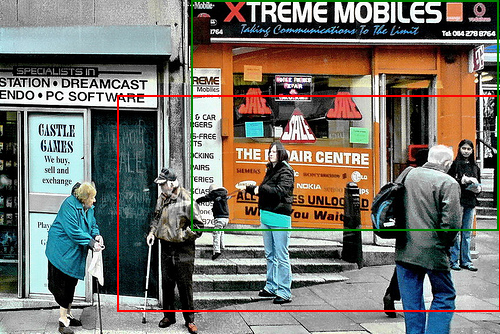




Accuracy@0.5: 0.0


In [ ]:
from time import sleep
from PIL import Image, ImageDraw
from tqdm.notebook import tqdm
import numpy as np
import json

cherry_picking = False

test_data = json.loads(open(test_json_path, "r").read())

acc05 = 0
N = 1
A = 0
found = 0

attempt = 0
cherry_picks = []
bar = tqdm(range(A, A+N), desc=f"Acc@05 = {0}:")
for sample_id in bar:
    for attempt in range(1):
        try:
            sample = test_data[sample_id]
            question, answer, gt_ans, img = process_sample(sample)

            width, height = img.size

            bbox_gt = sample.get("coords", get_bbox(gt_ans))
            bbox_gt_coorts = rel_to_abs(bbox_gt, width, height)

            answer = str(list(np.array(answer.to(dtype=torch.float32).cpu())))
            bbox_ans = correct_bbox(get_bbox(answer))
            bbox_ans_coors = rel_to_abs(bbox_ans, width, height)

            iou = get_iou(bbox_ans, bbox_gt)
            

            if iou>0:
                break
        except ValueError as ex:
            # print(f"Incorrect output format. Sample id: {sample_id}; answer: {answer}; error: {ex} ")
            bbox_ans = [0, 0, 0, 0]
            iou = 0
    
    if iou>0.5:
        acc05+=1
    found += 1
    bar.set_description(f"Acc@05 = {np.round(acc05/found, 3)}")

    draw = ImageDraw.Draw(img)
    draw.rectangle(bbox_ans_coors, outline="red", width=2)
    draw.rectangle(bbox_gt_coorts, outline="green", width=2)

    print("Sample id:", sample_id)    
    print("Attempts:", attempt)
    print("Question:", question)
    print("Answer:", answer)
    print("Gt answer:", gt_ans)
    print("IoU metrics:", iou)
    img.show()  # Отображение
    print("\n\n")
    
    

print("Accuracy@0.5:", acc05/N)
# interesting samples
# [101, 103, 105, 120, 123, 124, 200, 202, 211, 501, 601, 607, 606]